**I combined Vareational Autoencoder/decoder with GAN net to generate pictures from given images of faces.
Vareational Autoencoder is trained on given dataset of image faces. However the GAN combination is trained
on random generated vectors in a shape of images. After I trained Vareational Autoencoder, then I used VAE as
a generator in the GAN architecture. During the training of GAN the Encoder part of VAE is untrainable. Only
the Decoder part was trained in GAN Training.**

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)



In [2]:
!pip install -q tensorflow==2.6.4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.6.4 which is incompatible.
rich 12.6.0 req

In [3]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import tarfile


from kaggle_datasets import KaggleDatasets
print(tf.__version__)

2.6.4


In [4]:
import cv2
from tqdm import tqdm

In [5]:


#Zip_Path = '/kaggle/input/lfw-faces/lfw-deepfunneled.tgz'
# Dest_Path = '/kaggle/input/lfw-faces/lfw-deepfunneled'

# tar = tarfile.open(Zip_Path)
# tar.extractall(Dest_Path)
# tar.close()


In [6]:
from PIL import Image

In [7]:
import glob



ROOT_FOLDER = '/kaggle/input/lfw-faces/lfw-deepfunneled'

dataset = []
for path in glob.iglob(os.path.join(ROOT_FOLDER, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)

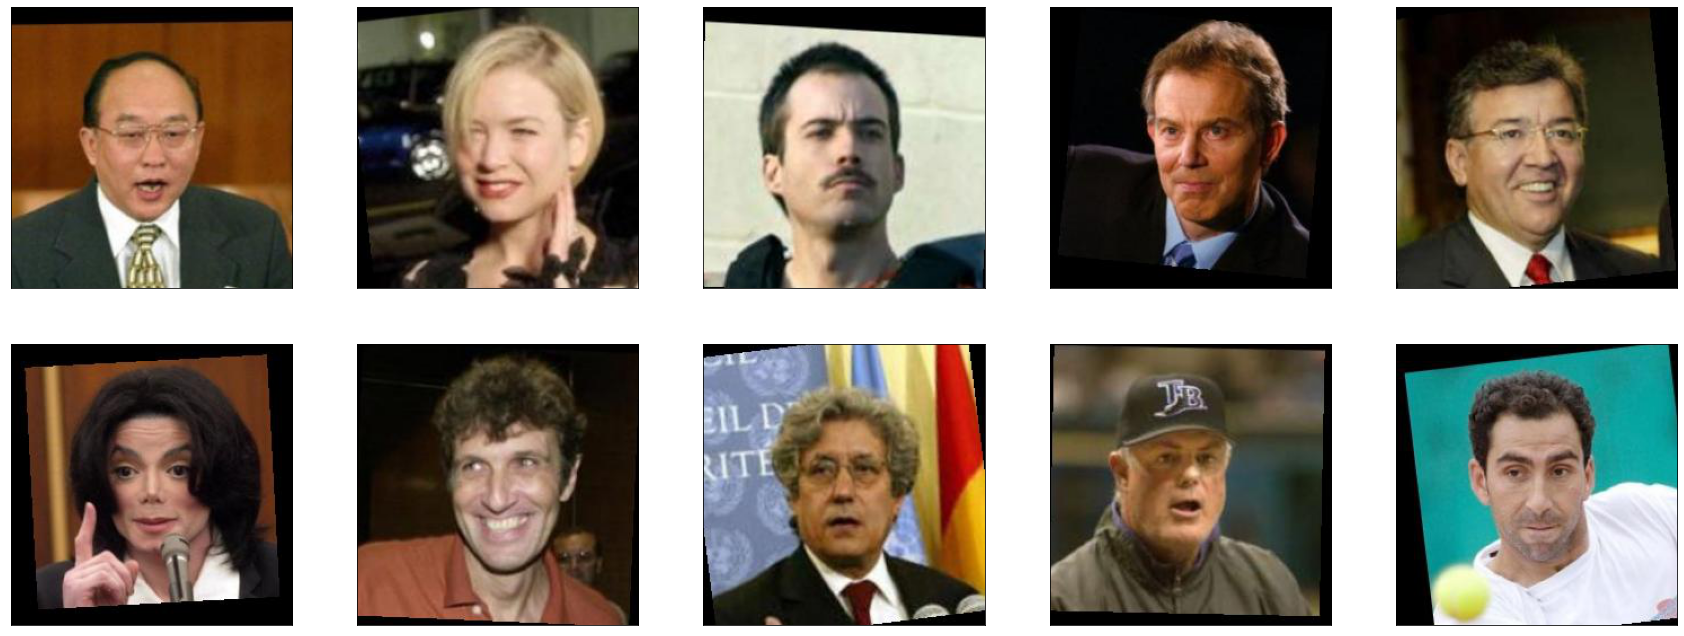

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_some_faces(samples):
    fig = plt.figure(figsize=(30, 30))
    num = samples.shape[0]
    
    for pic in range(num):
        ax = fig.add_subplot(5, 5, pic+1)
        img = mpimg.imread(samples[pic])
        ax.imshow(img)
        plt.xticks([]), plt.yticks([])
    plt.show()
    

plot_some_faces(dataset['path'].sample(10).values)

In [9]:


# The code below creates tensorflow image datasets for training and validation.

dataset = tf.keras.preprocessing.image_dataset_from_directory(ROOT_FOLDER, 
                                                              label_mode=None,
                                                              seed = 42,
                                                              subset = 'training',
                                                              validation_split = 0.05,
                                                              image_size=(64, 64), 
                                                              batch_size=32
                                                              )

dataset = dataset.map(lambda x: x / 255.0)




dataset_val = tf.keras.preprocessing.image_dataset_from_directory(ROOT_FOLDER, 
                                                              label_mode=None,
                                                              seed = 42,
                                                              subset = 'validation',
                                                              validation_split = 0.05,
                                                              image_size=(64, 64), 
                                                              batch_size=32
                                                              )

dataset_val = dataset_val.map(lambda x: x / 255.0)

Found 13233 files belonging to 1 classes.
Using 12572 files for training.


2023-01-03 07:57:00.030533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 07:57:00.176327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 07:57:00.177255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 07:57:00.180011: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 13233 files belonging to 1 classes.
Using 661 files for validation.


# VAE Encoder

In [10]:
# This is the encoder part for VAE


encoder_input = tf.keras.layers.Input(shape=(64, 64, 3))

# Define the encoder layers
encoder_conv_0 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', 
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(encoder_input)
leaky_re_lu = tf.keras.layers.LeakyReLU()(encoder_conv_0)
encoder_conv_1 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', 
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(leaky_re_lu)
leaky_re_lu_1 = tf.keras.layers.LeakyReLU()(encoder_conv_1)
encoder_conv_2 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', 
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(leaky_re_lu_1)
leaky_re_lu_2 = tf.keras.layers.LeakyReLU()(encoder_conv_2)
encoder_conv_3 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', 
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(leaky_re_lu_2)
leaky_re_lu_3 = tf.keras.layers.LeakyReLU()(encoder_conv_3)
flatten = tf.keras.layers.Flatten()(leaky_re_lu_3)

mu = tf.keras.layers.Dense(600)(flatten)
log_var = tf.keras.layers.Dense(600)(flatten)

# Define the encoder output
encoder_output = tf.keras.layers.Lambda(lambda x: x[0] + x[1])([mu, log_var])

# Create the model
vae_encoder = tf.keras.Model(inputs=encoder_input, outputs=[mu, log_var, encoder_output])

In [11]:
vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  147584      leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [12]:
# This is the decoder part for VAE

from keras import backend as K
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model


Z_DIM = 600


# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = L.Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = L.Dense(np.prod(shape_before_flattening), activation = 'relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder_input)
 
  x = L.Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = L.Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i),
                  kernel_regularizer=tf.keras.regularizers.l2(0.01)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = [8,8,64],
                                        conv_filters = [512,256,128,128,64,64,3],
                                        
                                        
                                        conv_kernel_size = [4,4,4,4,4,4,4],
                                        conv_strides = [1,1,1,2,1,2,2]
                                        )

In [13]:
vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 600)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              2461696   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 8, 8, 512)         524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 512)         0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 256)         0   

**VAE loss function is combined from two parts**

*Generative loss: This loss compares the model output with the model input. 
This can be the losses we used in the autoencoders, such as L2 loss.*

*Latent loss: This loss compares the latent vector with a zero mean, unit variance 
Gaussian distribution. The loss we use here will be the KL divergence loss. This 
loss term penalizes the VAE if it starts to produce latent vectors that are not from 
the desired distribution.**

In [14]:
# VAE loss function


def vae_loss(inp, target):
   
    
    mean_mu, log_var,z = vae_encoder.call(inp)
    
    pred = vae_decoder(z)
    
    mean = tf.math.reduce_mean(pred)
    std = tf.math.reduce_std(pred)
    
    mse_loss = 10000*tf.reduce_mean(tf.square(target - pred), axis = [1,2,3])
    KL_loss = - 0.5 * tf.math.reduce_sum(1 + log_var - tf.square(mean_mu) - tf.exp(log_var), axis = 1)
    
    
    return mse_loss + KL_loss, mean, std

In [15]:
# The code below is training code of VAE


from tensorflow.keras.optimizers import Adam, Adamax, RMSprop

#LEARNING_RATE = 0.0005

#optimizer = Adam(lr = LEARNING_RATE)

for e in range(90):
    LEARNING_RATE = 0.0005 / (1 + 0.01 * e)
    LEARNING_RATE = round(LEARNING_RATE, 7)
    print(LEARNING_RATE)
    optimizer = Adam(lr = LEARNING_RATE)
    mean_loss_value = 0
    for batch in dataset:
        
        with tf.GradientTape() as tape:
            loss_value, mean, std = vae_loss(batch, batch)
            
        if e > 15:
            if mean > 0.55 or mean < 0.18 or std > 0.45 or std < 0.14:
                
                neg_grad_vars = [(tf.negative(g), v) for g, v in grads]
                optimizer.apply_gradients(neg_grad_vars)
                with tf.GradientTape() as tape:
                    loss_value, mean, std = vae_loss(batch, batch)

        train_vars = vae_encoder.variables + vae_decoder.variables
        mean_loss_value += np.mean(loss_value.numpy())
        
        
        
        grads = tape.gradient(loss_value, train_vars)
        
        optimizer.apply_gradients(zip(grads, train_vars))
        
    print('epoch number  ', e, '  Train loss value is  ', mean_loss_value / len(dataset))
    mean_loss_value_val = 0
    for bat in dataset_val:
        loss_value = vae_loss(bat, bat)[0]
        mean_loss_value_val +=   np.mean(loss_value.numpy())
    print( 'Validation loss value is  ',mean_loss_value_val / len(dataset_val))
    

0.0005


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2023-01-03 07:57:07.014439: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-03 07:57:08.625627: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


epoch number   0   Train loss value is   361.9946217621859
Validation loss value is   217.5799262637184
0.000495
epoch number   1   Train loss value is   212.29503482110022
Validation loss value is   171.03062002999442
0.0004902
epoch number   2   Train loss value is   172.01992351347556
Validation loss value is   146.9779793875558
0.0004854
epoch number   3   Train loss value is   149.10702871851643
Validation loss value is   132.39955720447358
0.0004808
epoch number   4   Train loss value is   132.11106233863734
Validation loss value is   123.12709445045108
0.0004762
epoch number   5   Train loss value is   122.51576081487059
Validation loss value is   113.45436059860955
0.0004717
epoch number   6   Train loss value is   112.23139464400197
Validation loss value is   108.47847493489583
0.0004673
epoch number   7   Train loss value is   108.12500025237183
Validation loss value is   102.33899470738002
0.000463
epoch number   8   Train loss value is   102.99416126125035
Validation loss v

In [16]:
from keras.preprocessing.image import ImageDataGenerator

INPUT_DIM = (64,64,3)
BATCH_SIZE = 32

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(ROOT_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 13233 images belonging to 5749 classes.


std original images  tf.Tensor(0.2842426, shape=(), dtype=float32)
mean original images  tf.Tensor(0.35706168, shape=(), dtype=float32)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tf.Tensor(0.030893553, shape=(), dtype=float32)
std fake images  tf.Tensor(0.15822765, shape=(), dtype=float32)
mean fake images  tf.Tensor(0.37251613, shape=(), dtype=float32)


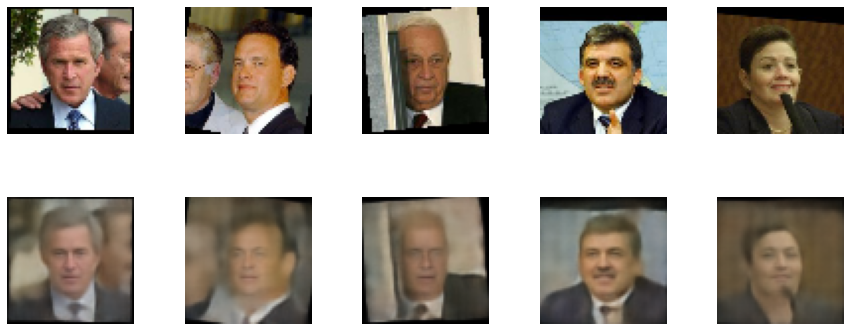

In [17]:
# Lets check how Images look like after VAE training

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:5]

def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:5]

  n_to_show = images.shape[0]
  print('std original images ', tf.math.reduce_std(images))
  print('mean original images ', tf.math.reduce_mean(images))
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  reconst_images = vae_encoder.predict(images)
  print(tf.math.reduce_std(reconst_images))
  reconst_images = vae_decoder.predict(reconst_images[0])
  print('std fake images ', tf.math.reduce_std(reconst_images))
  print('mean fake images ', tf.math.reduce_mean(reconst_images))
  fig = plt.figure(figsize=(15, 6))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

plot_compare_vae(images = example_images)         

# GAN

In [18]:
# The encoder part of VAE will not be trainable during the GAN training

for layer in vae_encoder.layers:
    layer.trainable = False
    # print(layer.trainable)


In [19]:
#Building Generator network from vae_encoder and vae_decoder

encoder_output = vae_encoder.outputs
dec_output = vae_decoder(encoder_output[2])
generator = tf.keras.Model(vae_encoder.input, dec_output, name = 'new_generator')

In [20]:
# The code below is discriminator part for GAN



discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(64, 64, 3)),
        L.Conv2D(512, kernel_size=4, strides=1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        L.LeakyReLU(alpha=0.2),
        L.Conv2D(256, kernel_size=4, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        L.LeakyReLU(alpha=0.2),
        L.Conv2D(128, kernel_size=4, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        L.LeakyReLU(alpha=0.2),
        L.Conv2D(128, kernel_size=4, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        L.LeakyReLU(alpha=0.2),
        L.Conv2D(64, kernel_size=4, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        L.LeakyReLU(alpha=0.2),
        L.Conv2D(128, kernel_size=4, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        L.LeakyReLU(alpha=0.2),
        L.Conv2D(128, kernel_size=4, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        L.LeakyReLU(alpha=0.2),
        L.Flatten(),
        L.Dropout(0.2),
        L.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [21]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 512)       25088     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 64, 64, 512)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 256)       2097408   
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)       

In [22]:
# GAN training code


import random

image_dimension = (32, 64,64,3)





def loss_function(labels, logits):
    
    loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(labels, logits)
    
    return loss_value





for epoch in range(30):
    discr_loss = 0
    gen_loss = 0
    
    LR = 0.0000002 / (1 + 0.01 * epoch)
    LR = round(LR, 10)
    optimizer = tf.keras.optimizers.Adam(LR)
    optimizer_gen = tf.keras.optimizers.Adam(LR)
    
    for index, real in enumerate(tqdm(dataset)):
        if index < 372:
            mean = random.randint(31,40)
            stdv = random.randint(27,30)
            batch_size = real.shape[0]
            vectors = vectors = tf.random.normal(shape = (image_dimension), mean = mean / 100, 
                                                 stddev = stdv / 100)
            
            fake = generator(vectors)
            
            mean = tf.math.reduce_mean(vectors)
            std = tf.math.reduce_std(vectors)
            
            
            
            
            
            if mean > 0.55 or mean < 0.16 or std > 0.45 or std < 0.16:
                
                
                
                grad_vars = zip(grads, generator.trainable_variables)
                neg_grad_vars = [(tf.negative(g), v) for g, v in grad_vars]
                optimizer_gen.apply_gradients(neg_grad_vars)
                
                grad_vars = zip(grads_d, discriminator.trainable_variables)
                neg_grad_vars = [(tf.negative(g), v) for g, v in grad_vars]
                optimizer.apply_gradients(neg_grad_vars)
                
                fake = generator(real)
                fake = fake * 5


            if index % 100 == 0:
                Image = tf.keras.preprocessing.image.img_to_array(fake[0])
        
                tf.keras.preprocessing.image.save_img(f"/kaggle/working/images{epoch}_{index}.png", Image)
                               
                
                
            with tf.GradientTape() as disc_tape:
                real_loss = loss_function(tf.ones((batch_size, 1)), discriminator(real))

                fake_loss = loss_function(tf.zeros((batch_size, 1)), discriminator(fake))
                total_disc_loss = (real_loss + fake_loss)/2
                discr_loss += total_disc_loss

            grads_d = disc_tape.gradient(total_disc_loss, discriminator.trainable_weights)
            optimizer.apply_gradients(zip(grads_d, discriminator.trainable_weights))

            with tf.GradientTape() as gen_tape:
                fake = generator(vectors)
                generator_output = discriminator(fake)

                generator_loss = loss_function(tf.ones((batch_size, 1)), generator_output)
                gen_loss += generator_loss
                


            grads = gen_tape.gradient(generator_loss, generator.trainable_weights)
            optimizer_gen.apply_gradients(zip(grads, generator.trainable_weights))
    print('discriminator loss  ', discr_loss)
    print('generator loss  ', gen_loss)
    
    


100%|██████████| 393/393 [01:51<00:00,  3.53it/s]


discriminator loss   tf.Tensor(269.26358, shape=(), dtype=float32)
generator loss   tf.Tensor(176.60767, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(269.0798, shape=(), dtype=float32)
generator loss   tf.Tensor(177.04556, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(268.8917, shape=(), dtype=float32)
generator loss   tf.Tensor(177.59227, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(268.73734, shape=(), dtype=float32)
generator loss   tf.Tensor(178.21878, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(268.63547, shape=(), dtype=float32)
generator loss   tf.Tensor(178.8428, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(268.63168, shape=(), dtype=float32)
generator loss   tf.Tensor(179.17555, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]


discriminator loss   tf.Tensor(268.62717, shape=(), dtype=float32)
generator loss   tf.Tensor(179.30473, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(268.7448, shape=(), dtype=float32)
generator loss   tf.Tensor(178.76337, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]


discriminator loss   tf.Tensor(268.77426, shape=(), dtype=float32)
generator loss   tf.Tensor(178.00986, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]


discriminator loss   tf.Tensor(268.774, shape=(), dtype=float32)
generator loss   tf.Tensor(177.21744, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]


discriminator loss   tf.Tensor(268.74625, shape=(), dtype=float32)
generator loss   tf.Tensor(176.60616, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]


discriminator loss   tf.Tensor(268.63742, shape=(), dtype=float32)
generator loss   tf.Tensor(176.2531, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(268.4612, shape=(), dtype=float32)
generator loss   tf.Tensor(176.37253, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]


discriminator loss   tf.Tensor(268.22852, shape=(), dtype=float32)
generator loss   tf.Tensor(176.75587, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.57it/s]


discriminator loss   tf.Tensor(267.98013, shape=(), dtype=float32)
generator loss   tf.Tensor(177.27701, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]


discriminator loss   tf.Tensor(267.78696, shape=(), dtype=float32)
generator loss   tf.Tensor(177.94432, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(267.6752, shape=(), dtype=float32)
generator loss   tf.Tensor(178.74632, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.54it/s]


discriminator loss   tf.Tensor(267.61554, shape=(), dtype=float32)
generator loss   tf.Tensor(179.37004, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(267.61478, shape=(), dtype=float32)
generator loss   tf.Tensor(179.62251, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(267.68845, shape=(), dtype=float32)
generator loss   tf.Tensor(179.29492, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(267.68637, shape=(), dtype=float32)
generator loss   tf.Tensor(178.55553, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]


discriminator loss   tf.Tensor(267.59686, shape=(), dtype=float32)
generator loss   tf.Tensor(178.21083, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]


discriminator loss   tf.Tensor(267.39398, shape=(), dtype=float32)
generator loss   tf.Tensor(177.87943, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]


discriminator loss   tf.Tensor(267.10898, shape=(), dtype=float32)
generator loss   tf.Tensor(177.69225, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(266.78146, shape=(), dtype=float32)
generator loss   tf.Tensor(177.56482, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(266.5283, shape=(), dtype=float32)
generator loss   tf.Tensor(177.62694, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(266.42715, shape=(), dtype=float32)
generator loss   tf.Tensor(177.50925, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(266.4746, shape=(), dtype=float32)
generator loss   tf.Tensor(176.8757, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.55it/s]


discriminator loss   tf.Tensor(266.57986, shape=(), dtype=float32)
generator loss   tf.Tensor(176.70622, shape=(), dtype=float32)


100%|██████████| 393/393 [01:50<00:00,  3.56it/s]

discriminator loss   tf.Tensor(266.624, shape=(), dtype=float32)
generator loss   tf.Tensor(176.25961, shape=(), dtype=float32)


std original images  tf.Tensor(0.3141197, shape=(), dtype=float32)
mean original images  tf.Tensor(0.3426785, shape=(), dtype=float32)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
std fake images  tf.Tensor(0.3276575, shape=(), dtype=float32)
mean fake images  tf.Tensor(0.3002509, shape=(), dtype=float32)


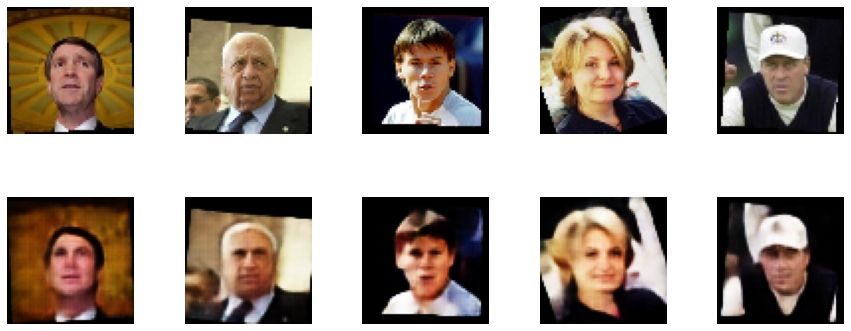

In [23]:
# Lets see how images look like generated from images after GAN Training

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:5]

def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:5]

  n_to_show = images.shape[0]
  print('std original images ', tf.math.reduce_std(images))
  print('mean original images ', tf.math.reduce_mean(images))
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  #reconst_images = vae_encoder.predict(images)
  #print(tf.math.reduce_std(reconst_images))
  reconst_images = generator.predict(images)
  print('std fake images ', tf.math.reduce_std(reconst_images))
  print('mean fake images ', tf.math.reduce_mean(reconst_images))
  fig = plt.figure(figsize=(15, 6))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      reconst_images[i] =   reconst_images[i]
      img = reconst_images[i].squeeze()
      
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

plot_compare_vae(images = example_images) 

tf.Tensor(0.35137472, shape=(), dtype=float32)
tf.Tensor(0.19035564, shape=(), dtype=float32)
tf.Tensor(0.18513696, shape=(), dtype=float32)


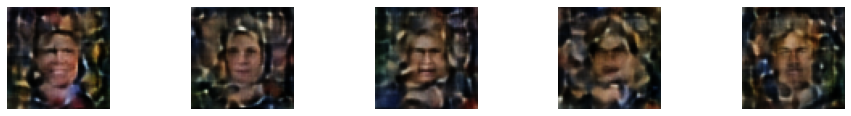

In [24]:
# Lets check images generated from random vectors

image_dimension = (32, 64,64,3)


def fake_image_generator(image_dimension, numbers_to_print):
    vectors = tf.random.normal(shape = (image_dimension), mean = 0.35, stddev = 0.28)
    print(tf.math.reduce_mean(vectors[0]))
    fake_images = generator.predict(vectors)
    print(tf.math.reduce_mean(fake_images[0]))
    #fake_images = vae_decoder.predict(fake_images[0][:5])
    print(tf.math.reduce_mean(fake_images))

    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    
    for i in range(numbers_to_print):
        img = fake_images[i].squeeze()
        sub = fig.add_subplot(2, numbers_to_print, i+numbers_to_print+1)
        sub.axis('off')
        sub.imshow(img)
        
        

fake_image_generator(image_dimension, 5)

In [25]:
# ###### batch_size = 32
# image_dimension = (32, 128,128,3)


# def fake_image_generator(image_dimension, numbers_to_print):
#     vectors = tf.random.normal(shape = (image_dimension), mean = 0.37, stddev = 0.27)
#     print(tf.math.reduce_mean(vectors[0]))
#     fake_images = generator(vectors)
   
#     print(tf.math.reduce_mean(fake_images[0]))
#     #fake_images = vae_decoder.predict(fake_images[0][:5])
#     print(tf.math.reduce_mean(fake_images))

#     fig = plt.figure(figsize=(15, 15))
#     fig.subplots_adjust(hspace=0.8, wspace=0.8)
    
#     for i in range(numbers_to_print):
#         img = fake_images[i]#.squeeze()
#         sub = fig.add_subplot(2, numbers_to_print, i+numbers_to_print+1)
#         sub.axis('off')
#         sub.imshow(img)
        
        

# fake_image_generator(image_dimension, 5)